Imports (messy needs cleaning)

In [1]:
from xpinn import XPINN
import optax
from type_util import Array
from jax import hessian, jit, vmap, grad
import jax.numpy as np
import json

from jax import config

config.update("jax_enable_x64", True)

#### Initalizing the XPINN

In this expereiment we'll only deal with a single pinn for the entire domain

In [2]:
from utils import data_path

file = data_path / "navier_stokes_pinn_train.json"
file_test = data_path / "navier_stokes_pinn_test.json"
activation = np.tanh
xpinn = XPINN(file, activation)

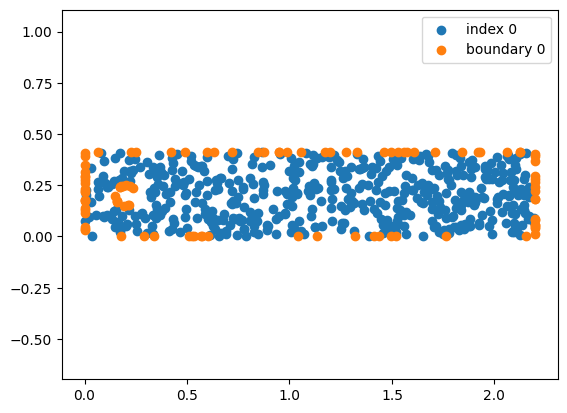

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.axis("equal"
)
for i, pinn in enumerate(xpinn.PINNs):
    checkout = pinn.interior
    plt.scatter(checkout[:, 0], checkout[:, 1], label=f"index {i}")
    plt.scatter(pinn.boundary[:, 0], pinn.boundary[:, 1], label=f"boundary {i}")

for interface in xpinn.Interfaces:
    a, b = interface.indices
    p = interface.points
    plt.scatter(p[:, 0], p[:, 1], label=f"interface {a}-{b}")

plt.legend()

# Problem specifications

In this project we attempt to replicate the cylinder-wake navier stokes benchmark from [DFG benchmark 2D-1](https://wwwold.mathematik.tu-dortmund.de/~featflow/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark1_re20.html). Which is a simulation of a incompresible 2D fluid flow hitting a cylinder in the above rectangle. In the dortmund article they have used U to denote vector for the fluid flow velocity, in this code however we found it convenient to isolate the x- and y-flow which is denoted respectively as u and v throughout the code. (FEEL FREE TO CHANGE THIS)

### The interior PDE constraints
In the DFG benchmark 2D-1, the PDE conditions are given by the Navier-Stokes equations:

$$-\nu \nabla^2 \mathbf{u} + (\mathbf{u} \cdot \nabla)\mathbf{u} + \nabla p = \mathbf{0}, \hspace{3mm} \nabla \cdot \mathbf{u} = 0$$

$\nu = 0.001$.
In our notation, which isolates the x- and y-flow as "u" and "v", the PDE expressions for the second-order spatial derivatives can be written as:

$$-\nu (u_{xx} + u_{yy}) + u u_x + v u_y + p_x = 0,$$

$$-\nu (v_{xx} + v_{yy}) + u v_x + v v_y + p_y = 0$$

Our zero divergence from incompressibility:

$$ u_x + v_y = 0$$

Let's denote our PDE conditions the x and y direction as f and g, giving


$$ f = -\nu (u_{xx} + u_{yy}) + u u_x + v u_y + p_x = 0,$$

$$g = -\nu (v_{xx} + v_{yy}) + u v_x + v v_y + p_y = 0$$



In order to impose the zero divergence we simply let our network  ($\mathcal{N}_{\theta}$)  predict the stream function $\psi$ and the preassure $p$.

$$\mathcal{N}_{\theta}:\mathbb{R}^3 \to \mathbb{R}^2, \hspace{4mm}(x,y,t) \to (\psi, p)$$

Then $u$ and $v$ is given by

$$ u = \psi_y,  \hspace{4mm} v = -\psi_y$$

From this we see that we require a lot of derivatives in order to define our loss. Let's initalize a network and define these
 


In [4]:
from typing import Callable
from type_util import Params, Array
from base_network import neural_network

LFunc = Callable[[Params, dict[str, Array]], Array]

model = neural_network(activation)
v_model = vmap(model, (None, 0))


#### Derivatives of $\psi$

In [5]:
psi_func = lambda params, xyt: model(params, xyt)[0]

hess_psi = hessian(psi_func, argnums=1)
d_psi_dxyt = grad(psi_func, argnums=1)

u_x = lambda params, xyt: hess_psi(params, xyt)[0,1] #psi_yx
u_y = lambda params, xyt: hess_psi(params, xyt)[1,1] #psi_yy
u_xx = lambda params, xyt: grad(u_x, argnums=1)(params, xyt)[0] #psi_yxx
u_t = lambda params, xyt: hess_psi(params, xyt)[1,2] #psi_ty
u_yy = lambda params, xyt: grad(u_y, argnums=1)(params, xyt)[1] #psi_yyy

v_y = lambda params, xyt: -hess_psi(params, xyt)[0,1] #-psi_yx
v_x = lambda params, xyt: -hess_psi(params, xyt)[0,0] #-psi_xx
v_t = lambda params, xyt: -hess_psi(params, xyt)[1,2] #-psi_ty
v_xx = lambda params, xyt: grad(v_x, argnums=1)(params, xyt)[0] #-psi_xxx
v_yy = lambda params, xyt: grad(v_y, argnums=1)(params, xyt)[1] #-psi_yyy


u = lambda params, xyt: d_psi_dxyt(params, xyt)[1]
v = lambda params, xyt: -d_psi_dxyt(params, xyt)[0]

In [53]:
para = xpinn.PINNs[0].params
point = np.array([0.5, 0.5, 0.5])

u(para, point), u_x(para, point), u_y(para, point), u_t(para, point), u_xx(para, point), u_yy(para, point)
v(para, point), v_x(para, point), v_y(para, point), v_t(para, point), v_xx(para, point), v_yy(para, point)

(Array(-0.20356295, dtype=float64),
 Array(0.10094374, dtype=float64),
 Array(-0.11103788, dtype=float64),
 Array(0.02046758, dtype=float64),
 Array(0.03966144, dtype=float64),
 Array(0.08444724, dtype=float64))

#### Derivatives of p

In [6]:
p = lambda params, xyt: model(params, xyt)[1]

p_x = lambda params, xyt: grad(p, argnums=1)(params, xyt)[0]
p_y = lambda params, xyt: grad(p, argnums=1)(params, xyt)[1]

In [54]:
p(para, point), p_x(para, point), p_y(para, point)

(Array(0.13911578, dtype=float64),
 Array(0.09210014, dtype=float64),
 Array(-0.01347172, dtype=float64))

#### Residual functions f and g

In [7]:
def navier_stokes_residual_factory(index: int, nu: float) -> Callable[[Params, dict[str, Array]], Array]:
                                                   
    def f(params, xyt):
        return (u_t(params, xyt) + u(params, xyt)*u_x(params, xyt) + 
                v(params, xyt)*u_y(params, xyt) + p_x(params, xyt) - 
                nu*(u_xx(params, xyt) + u_yy(params, xyt)))
    def g(params, xyt):
        return (v_t(params, xyt) + u(params, xyt)*v_x(params, xyt) + 
                v(params, xyt)*v_y(params, xyt) + p_y(params, xyt) - 
                nu*(v_xx(params, xyt) + v_yy(params, xyt)))
        
    def residual(params, xyt):
        return f(params, xyt)**2 + g(params, xyt)**2
    
    v_residual = jit(vmap(residual, (None, 0)))
    xpinn.PINNs[index].v_residual = v_residual
    
    def interior_loss(params: Params, points: dict[str, Array]) -> Array:
        pts = points["interior"]
        return np.mean(v_residual(params, pts))
    
    return interior_loss

### Boundary conditions

#### Wall boundary conditions
There are three 'walls' in our domain, the top and bottom walls and the cylinder. On these walls, we have the so called noslip conditions. That is there is no flow parallel to the boundary exactly on the boundary. The walls are also impermeable, thus the flow velocity is exactly zero on these walls. In the [DFG benchmark 2D-1](https://wwwold.mathematik.tu-dortmund.de/~featflow/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark1_re20.html) this is notated as. 


""


For the lower and upper walls $\Gamma_1=[0,2.2]\times0$ and $\Gamma_2=[0,2.2]\times0.41$, as well as the boundary $S=\partial B_r(0.2,0.2)$, no-slip boundary conditions are defined:

$$u_{|{\Gamma_1}} = u_{|{\Gamma_3}} = u_{|_S} = \boldsymbol{0}$$

""

Using our notation we get

$$u_{|{\Gamma_1}} = u_{|{\Gamma_3}} = u_{|_S} = 0$$
$$v_{|{\Gamma_1}} = v_{|{\Gamma_3}} = v_{|_S} = 0$$


#### Left boundary

On the left bondary we have a polynomial inflow

$$u = \frac{4U y(0.41-y)}{0.41^2}$$
$$v = 0$$

$U = 0.3$ 

#### Right boundary 

On the right boundary we have the do-nothing boundary condition. [DFG benchmark 2D-1](https://wwwold.mathematik.tu-dortmund.de/~featflow/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark1_re20.html) denotes this as

$$\nu\partial_{\eta} u - p\eta = 0$$

where $\nu$ denotes the unit normal vector to the boundary, which is just $(1,0)$. In our notation this is rather simple

$$
\nu u_x  - p = 0 
$$

$$
\nu u_y  = 0 
$$


Inflow 

In [8]:
U = 0.3

inflow_func = lambda y: 4 * U * y * (0.41 - y)/0.41**2
v_inflow_func = vmap(inflow_func)


In [87]:
from jax import lax

def boundary_loss_factory(inflow_func: Callable[[Array], Array], nu:float) -> Callable[[Params, dict[str, Array]], Array]:
    
    def left_boundary_loss(params, xyt):
        return (u(params, xyt) - inflow_func(xyt[1]))**2 + v(params, xyt)**2
    
    def wall_boundary_loss(params, xyt):
        return u(params, xyt)**2 + v(params, xyt)**2
        
    def right_boundary_loss(params, xyt):
        return nu*u_x(params, xyt)**2 + nu*u_y(params, xyt)**2
    
    v_left_boundary_loss = vmap(left_boundary_loss, (None, 0))
    v_wall_boundary_loss = vmap(wall_boundary_loss, (None, 0))
    v_right_boundary_loss = vmap(right_boundary_loss, (None, 0))
    
    def boundary_loss(params: Params, points: dict[str, Array]) -> Array:
        bound = points['boundary']
        on_left = np.isclose(bound[:, 0], 0)
        on_right = np.isclose(bound[:, 0], 2.2)
        on_wall = ~(on_left | on_right)



        #left_pts = bound[on_left]
        #right_pts = bound[on_right]
        #wall_pts = bound[on_wall]

       
        left = v_left_boundary_loss(params, left_pts)
        right = v_right_boundary_loss(params, right_pts)
        wall = v_wall_boundary_loss(params, wall_pts)
    
        all = np.concatenate((left,  wall, right))
     
        return np.mean(all)
    
    return boundary_loss
    

In [92]:
p0 = xpinn.PINNs[0]
p0.boundary_loss = boundary_loss_factory(inflow_func, nu=0.01)
p0.interior_loss = navier_stokes_residual_factory(0, nu=0.01)
p0.create_loss()


<PjitFunction of <function PINN.create_loss.<locals>.loss at 0x000001F797CF5E40>>

In [89]:
# Sample inputs
params = xpinn.PINNs[0].params


points = xpinn.main_args[0]

loss2 = boundary_loss_factory(inflow_func, nu=0.01)
# Run the boundary_loss function
loss = p0.boundary_loss(params, points)

print(loss)


#print(points)

0.16118311590719206


In [93]:
shapes = [[3, 20, 20, 20, 2]]
for pinn, shape in zip(xpinn.PINNs, shapes):
    exponential_decay = optax.exponential_decay(
        init_value=0.001,
        transition_steps=10000,
        transition_begin=15000,
        decay_rate=0.1,
        end_value=0.0000001,
    )
    optimizer = optax.adam(learning_rate=0.0008)

    pinn.init_params(shape, optimizer)

In [94]:
n_iter = 1000
losses = xpinn.run_iters(n_iter)

NonConcreteBooleanIndexError: Array boolean indices must be concrete; got ShapedArray(bool[100])

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError

precompute inflow?

In [ ]:
def calculate_inflow(v_inflow_func, file):
        inflow = []
        with open(file, "r") as infile:
                data = json.load(infile)
                for i in range(len(data['XPINNs'])):
                        left_pts = data['XPINNs'][i]['left boundary']
                        inflow.append(v_inflow_func(np.array(left_pts)[:,1]))
        return inflow

file = data_path / "navier_stokes_pinn_train.json"
inflow = calculate_inflow(v_inflow_func, file)
